  0%|          | 0/500 [00:00<?, ?it/s]

Episode: 0, Total reward: -200.0, Epsilon: 0.43080185560799106
Episode: 1, Total reward: -200.0, Epsilon: 0.1580861105294992
Episode: 2, Total reward: -200.0, Epsilon: 0.058010934765067
Episode: 3, Total reward: -200.0, Epsilon: 0.02128756625768776
Episode: 4, Total reward: -200.0, Epsilon: 0.00998645168764533
Episode: 5, Total reward: -200.0, Epsilon: 0.00998645168764533
Episode: 6, Total reward: -200.0, Epsilon: 0.00998645168764533
Episode: 7, Total reward: -200.0, Epsilon: 0.00998645168764533
Episode: 8, Total reward: -200.0, Epsilon: 0.00998645168764533
Episode: 9, Total reward: -200.0, Epsilon: 0.00998645168764533
Episode: 10, Total reward: -200.0, Epsilon: 0.00998645168764533
Episode: 11, Total reward: -200.0, Epsilon: 0.00998645168764533
Episode: 12, Total reward: -200.0, Epsilon: 0.00998645168764533
Episode: 13, Total reward: -200.0, Epsilon: 0.00998645168764533
Episode: 14, Total reward: -200.0, Epsilon: 0.00998645168764533
Episode: 15, Total reward: -200.0, Epsilon: 0.0099864

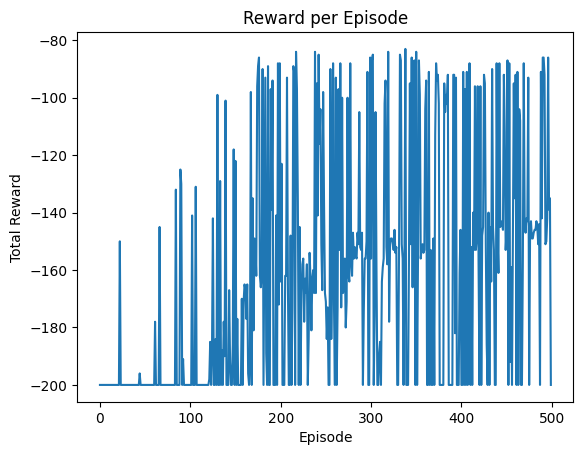

In [3]:
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from tqdm.notebook import tqdm
import pygame
import cv2
import matplotlib.pyplot as plt

# Inicialización de pygame para la visualización
pygame.init()
screen = pygame.display.set_mode((800, 600))
pygame.display.set_caption("Mountain Car")

# Definición de la red neuronal para el agente DQN
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Definición del agente DQN
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.Q = DQN(state_size, action_size)
        self.Q_target = DQN(state_size, action_size)
        self.Q_target.load_state_dict(self.Q.state_dict())
        self.optimizer = optim.Adam(self.Q.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        self.replay_buffer = deque(maxlen=10000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_values = self.Q(state)
        return torch.argmax(action_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        minibatch = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        current_q_values = self.Q(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.Q_target(next_states).max(1)[0]
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        loss = self.criterion(current_q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        self.Q_target.load_state_dict(self.Q.state_dict())

# Preparación del entorno y del entrenamiento
env = gym.make('MountainCar-v0', render_mode='human')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
batch_size = 32
episodes = 500
rewards = []
best_reward = -float('inf')
best_frames = []

for e in tqdm(range(episodes)):
    state = env.reset()[0]
    total_reward = 0
    done = False
    frame_list = []
    while not done:
        pygame.event.pump()
        action = agent.act(state)
        next_state, reward, done, truncated, _ = env.step(action)
        done = done or truncated
        total_reward += reward
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        frame = env.render()
        if frame is not None and len(frame.shape) == 3:
            frame = np.transpose(frame, (1, 0, 2))
            frame_list.append(frame)
            surf = pygame.surfarray.make_surface(frame)
            screen.blit(surf, (0, 0))
            pygame.display.update()

        if len(agent.replay_buffer) > batch_size:
            agent.replay(batch_size)

    agent.update_target_network()
    rewards.append(total_reward)
    if total_reward > best_reward:
        best_reward = total_reward
        best_frames = frame_list[:1200]

    print(f"Episode: {e}, Total reward: {total_reward}, Epsilon: {agent.epsilon}")

# Grabación del mejor episodio
#  if best_frames:
   # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    #out = cv2.VideoWriter('best_episode1.avi', fourcc, 20.0, (800, 600))
    #for frame in best_frames:
        #out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    #out.release()

# Visualización de las recompensas por episodio
plt.plot(rewards)
plt.title('Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

pygame.quit()
env.close()
